In [9]:
import sys, os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.95'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from jax.lib import xla_bridge
platform = xla_bridge.get_backend().platform
import jax
jax.config.update('jax_platform_name', platform)
jax.config.update("jax_enable_x64", True)
import jax
# Change the current working directory to the desired path
# os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')
import pathlib
curr_path = pathlib.Path().absolute()
abs_path_data = os.path.abspath(curr_path / "../../data/") 
abs_path_src = os.path.abspath(curr_path / "../../src/") 
abs_path_results = os.path.abspath(curr_path / "../../results/") 
sys.path.append((curr_path))
sys.path.append((abs_path_data))
sys.path.append((abs_path_results))
sys.path.append(abs_path_src)

from jax import config
config.update("jax_enable_x64", True)
import scipy.interpolate as interp
import pickle as pk
import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')
import matplotlib
%matplotlib inline
# deproj = sys.argv[1]
# probe = sys.argv[2]


In [10]:
import dill
# df = dill.load(open(f'/global/cfs/cdirs/lsst/www/shivamp/GODMAX/results/chains/mcmc_probe_gty_deproj_cib_1p7_dBeta_200_200_num_chains_8_NUTS_update.pkl','rb'))
# df = dill.load(open(f'/global/cfs/cdirs/lsst/www/shivamp/GODMAX/results/chains/mcmc_probe_gty_deproj_cib_1p7_dBeta_2000_500_num_chains_8_NUTS_update.pkl','rb'))
# df = dill.load(open(f'/global/cfs/cdirs/lsst/www/shivamp/GODMAX/results/chains/mcmc_probe_xip_xim_deproj_cib_1p7_dBeta_6000_1500_num_chains_16_NUTS_update.pkl','rb'))
# df = dill.load(open(f'/global/cfs/cdirs/lsst/www/shivamp/GODMAX/results/chains/mcmc_probe_gty_deproj_cib_1p7_dBeta_6000_1500_num_chains_16_NUTS_update.pkl','rb'))
# df = dill.load(open(f'/global/cfs/cdirs/lsst/www/shivamp/GODMAX/results/chains/mcmc_probe_all_deproj_cib_1p7_dBeta_6000_1500_num_chains_16_NUTS_update.pkl','rb'))
# df = dill.load(open(f'/global/cfs/cdirs/lsst/www/shivamp/GODMAX/results/chains/mcmc_probe_all_deproj_cib_1p7_dBeta_2000_1000_num_chains_16_sample_Mc_NUTS_update.pkl','rb'))
df = dill.load(open(f'/global/cfs/cdirs/lsst/www/shivamp/GODMAX/results/chains/mcmc_probe_all_deproj_cib_1p7_dBeta_4000_2500_num_chains_16_sample_Mc_NUTS_update.pkl','rb'))
# df = dill.load(open(f'/global/cfs/cdirs/lsst/www/shivamp/GODMAX/results/chains/mcmc_probe_all_deproj_cib_1p7_dBeta_4000_2500_num_chains_16_sample_thetaco_NUTS_update.pkl','rb'))
df.keys()




dict_keys(['A_IA', 'A_IA_base', 'Delta_z_bias_array', 'Delta_z_bias_array_decentered', 'Ob0', 'Ob0_base', 'Om0', 'Om0_base', 'alpha_nt', 'alpha_nt_base', 'diverging', 'eta_IA', 'eta_IA_base', 'h', 'h_base', 'log10_Mc0', 'log10_Mc0_base', 'mult_shear_bias_array', 'mult_shear_bias_array_decentered', 'ns', 'ns_base', 'nu_theta_ej_M', 'nu_theta_ej_M_base', 'nu_z', 'nu_z_base', 'potential_energy', 'sigma8', 'sigma8_base', 'theta_ej_0', 'theta_ej_0_base'])

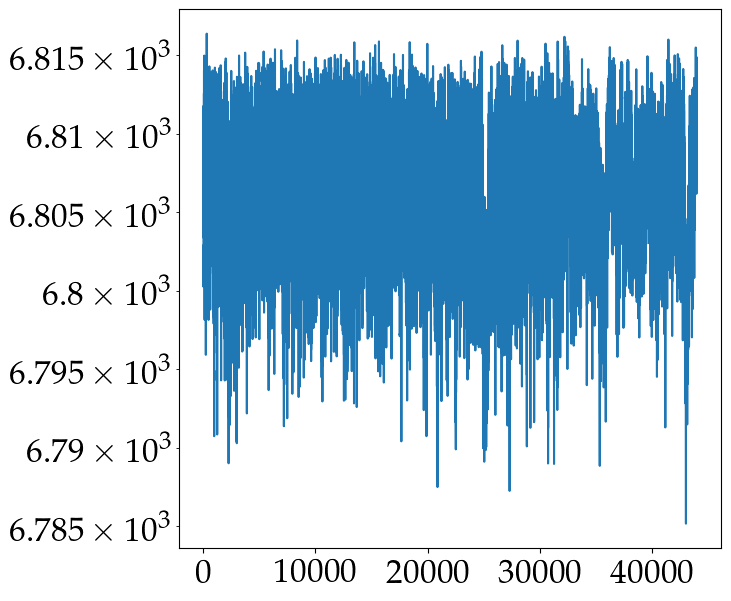

In [8]:
# df['potential_energy'].shape
pl.figure()
# pl.plot(df['potential_energy'][20000:])
pl.plot(-1*df['potential_energy'][20000:])
pl.yscale('log')
# df['potential_energy']




In [11]:
# df['s'].shape
# df
samps = []
keys = []
for key in df:
    if ('base' not in key) and ('decentered' not in key):
        if ('Delta_z_bias_array' in key) or ('mult_shear_bias_array' in key):
            for jb in range(4):
                samps.append(df[key][:, jb])
                keys.append(key + '_' + str(jb))
                print(df[key][:, jb].shape)
        # print(samps[0].shape)
        # print(df[key].shape)
        else:
            samps.append(df[key])
            keys.append(key)

samps = np.array(samps).T
ind_sigma8 = keys.index('sigma8')
ind_Om = keys.index('Om0')
samp_S8 = samps[:,ind_sigma8] * (samps[:,ind_Om]/0.3)**0.5

samps = np.concatenate([samps, samp_S8[:,None]], axis=1)
keys.append('S8')

import getdist
from getdist import plots, MCSamples
# names = ["x%s"%i for i in range(ndim)]
# labels =  ["x_%s"%i for i in range(ndim)]

names = keys

# labels = [r'$A_{\rm IA}$',
#  r'$\Delta z_1$',
#  r'$\Delta z_2$',
#  r'$\Delta z_3$',
#  r'$\Delta z_4$',
#  r'$\Omega_b$',
#  r'$\Omega_m$',
#  r'$\eta_{\rm IA}$',
#  r'$h$',
#  r'$m_1$',
#  r'$m_2$',
#  r'$m_3$',
#  r'$m_4$',
#  r'$n_s$',
#  r'$\nu^{M}_{\theta_{\rm ej}}$',
#  r'$\nu^{z}_{\theta_{\rm ej}}$',
# #  'nu_theta_ej_z',
#  r'$\sigma_8$',
#  r'$\theta_{\rm ej, 0}$',
#  r'$S_8$'
#  ]

labels_all = {'A_IA':r'$A_{\rm IA}$',
 'Ob0':r'$\Omega_b$',
 'Om0':r'$\Omega_m$',
 'eta_IA':r'$\eta_{\rm IA}$',
 'log10_Mc0':r'$\log(M_c)$',
 'theta_co_0':r'$\theta_{\rm co, 0}$',
 'gamma_rhogas':r'$\gamma$',
 'nu_z':r'$\nu_z$',
 'h':r'$h$',
 'ns':r'$n_s$',
 'nu_theta_ej_M':r'$\nu^{M}_{\theta_{\rm ej}}$',
 'nu_theta_ej_z':r'$\nu^{z}_{\theta_{\rm ej}}$',
#  'nu_theta_ej_z',
 'sigma8':r'$\sigma_8$',
 'theta_ej_0':r'$\theta_{\rm ej, 0}$',
 'S8':r'$S_8$',
 'alpha_nt':r'$\alpha_{\rm nt}$'
}

labels = []

for key in keys:
    if key in labels_all.keys():
        labels.append(labels_all[key])
    else:
        labels.append(r'm')

# samps = samps[60000:80000,:]
# samples_xipxim = MCSamples(samples=samps,names = names, labels = labels)




(64000,)
(64000,)
(64000,)
(64000,)
(64000,)
(64000,)
(64000,)
(64000,)


In [12]:
samps = np.array(samps)
ind_sigma8 = keys.index('sigma8')
ind_Om = keys.index('Om0')
samp_S8 = samps[:,ind_sigma8] * (samps[:,ind_Om]/0.3)**0.5

samps = np.concatenate([samps, samp_S8[:,None]], axis=1)
keys.append('S8')

# samps = samps[60000:80000,:]
samples = MCSamples(samples=samps,names = names, labels = labels)



Removed no burn in


In [13]:
samps.shape




(64000, 24)

In [14]:
# samps = np.array(samps)
# ind_sigma8 = keys.index('sigma8')
# ind_Om = keys.index('Om0')
# samp_S8 = samps[:,ind_sigma8] * (samps[:,ind_Om]/0.3)**0.5

# samps = np.concatenate([samps, samp_S8[:,None]], axis=1)
# keys.append('S8')

ind_frac_rm = 0.5
samps_sel = samps.reshape(16,-1, samps.shape[-1])
nsamp_per_chain = samps_sel.shape[1]
nrm = int(ind_frac_rm * nsamp_per_chain)
samps_sel = samps_sel[:, nrm:, :]
samps = samps_sel.reshape(-1, samps_sel.shape[-1])

# samps = samps[60000:80000,:]
samples = MCSamples(samples=samps,names = names, labels = labels)


Removed no burn in


In [15]:
samps.shape
# 6000*0.2
# samps_sel.shape
# nrm




(32000, 24)

In [16]:
# samps.shape
from numpyro.diagnostics import gelman_rubin
ind_gr = ind_sigma8
gr = gelman_rubin(samps[:, ind_gr].reshape(16, -1))
print(gr)




/global/cfs/cdirs/lsst/www/shivamp/env/jax_pm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.3134098553676394


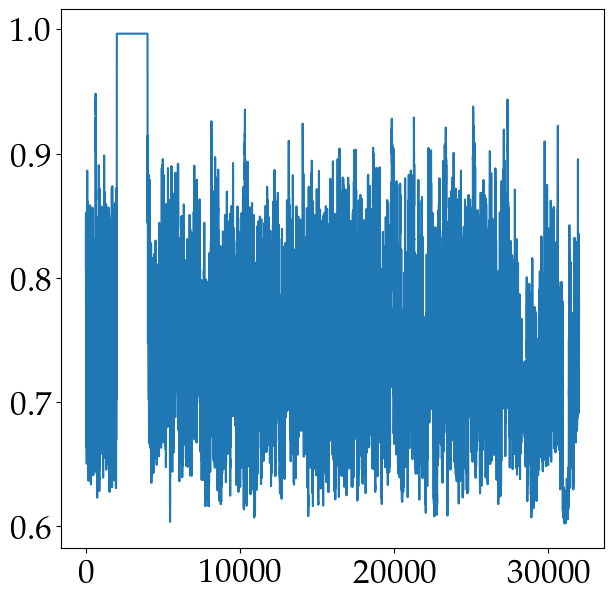

In [18]:
# samps.shape
pl.figure()
pl.plot(samps[:,ind_sigma8])




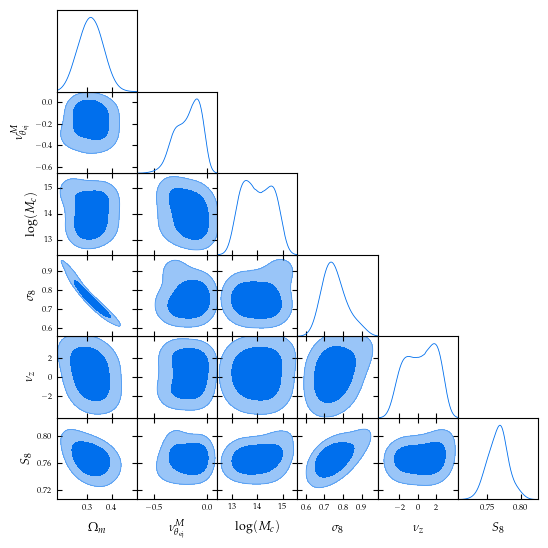

In [18]:
# params = ['Om0', 'nu_theta_ej_M', 'nu_theta_ej_z', 'sigma8', 'theta_ej_0', 'S8']
params = ['Om0', 'nu_theta_ej_M', 'log10_Mc0', 'sigma8', 'nu_z', 'S8']
# params = ['Om0', 'nu_theta_ej_M', 'theta_co_0', 'sigma8', 'gamma_rhogas', 'S8']

g = plots.get_subplot_plotter(width_inch=6)
# g.triangle_plot([samples_xipxim, samples_gty, samples_all], params, filled=True)
g.triangle_plot([samples], params, filled=True)
# g.triangle_plot([samples], filled=True)
save_plot_dir = '/mnt/home/spandey/ceph/GODMAX/results/ACTxDES/'
# g.export(save_plot_dir + f'triangle_plot_probe_{probe}_deproj_cib_1p7_dBeta_20000_1500_num_chains_5.png')






In [8]:
samps.shape
# pl.figure()
# pl.plot(samps[:,ind_sigma8])
# np.array(samps).T.shape
# keys
# ind_sigma8 = keys.index('sigma8')
# ind_Om = keys.index('Om0')
# print(ind_sigma8, ind_Om)


(1600, 23)

In [9]:
names


['A_IA',
 'Delta_z_bias_array_0',
 'Delta_z_bias_array_1',
 'Delta_z_bias_array_2',
 'Delta_z_bias_array_3',
 'Ob0',
 'Om0',
 'alpha_nt',
 'diverging',
 'eta_IA',
 'h',
 'mult_shear_bias_array_0',
 'mult_shear_bias_array_1',
 'mult_shear_bias_array_2',
 'mult_shear_bias_array_3',
 'ns',
 'nu_theta_ej_M',
 'nu_theta_ej_z',
 'potential_energy',
 'sigma8',
 'theta_ej_0',
 'S8',
 'S8']

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'



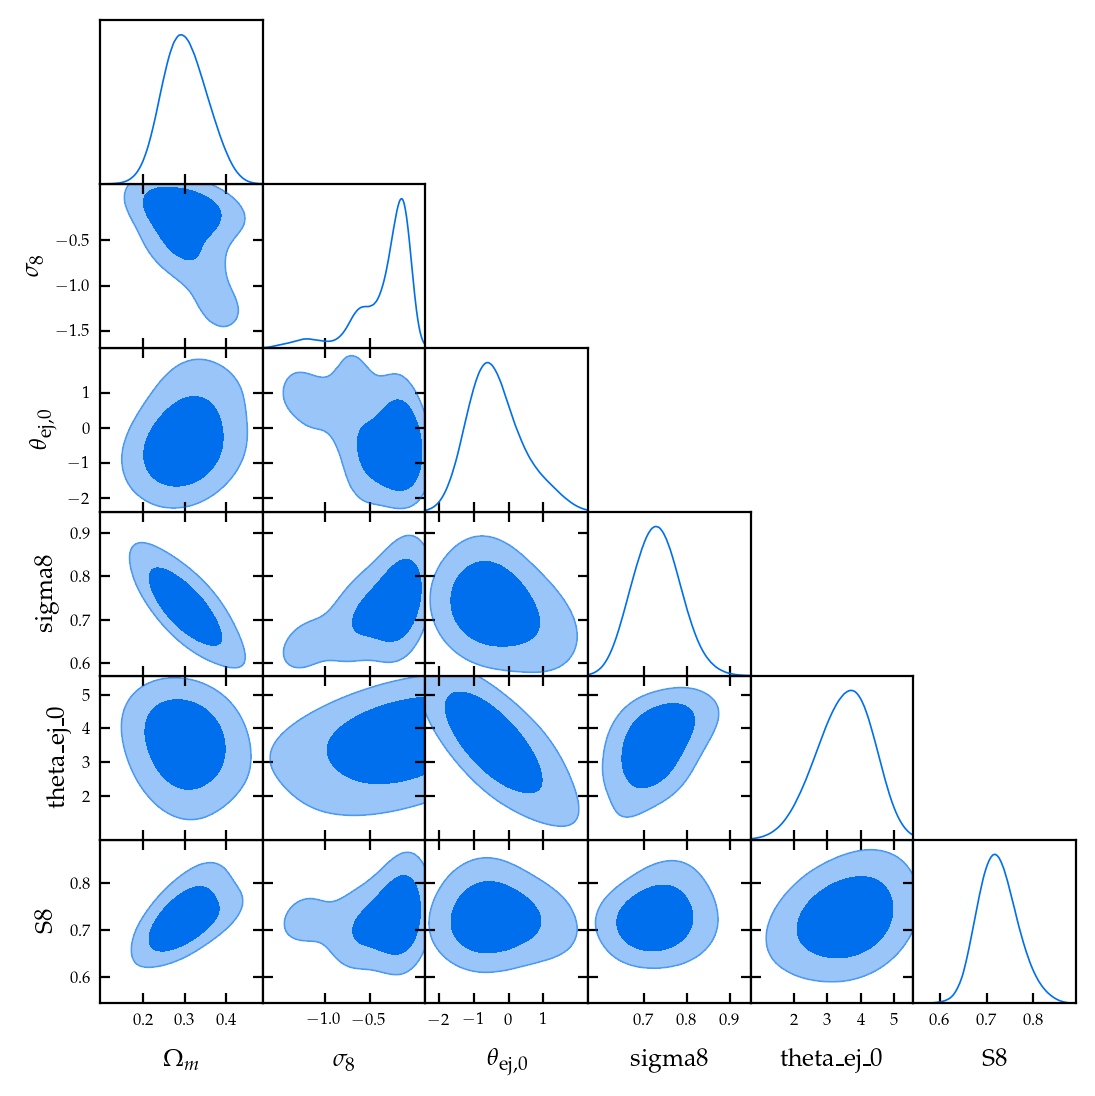

In [11]:
params = ['Om0', 'nu_theta_ej_M', 'nu_theta_ej_z', 'sigma8', 'theta_ej_0', 'S8']

g = plots.get_subplot_plotter(width_inch=6)
# g.triangle_plot([samples_xipxim, samples_gty, samples_all], params, filled=True)
g.triangle_plot([samples], params, filled=True)
# g.triangle_plot([samples], filled=True)
save_plot_dir = '/mnt/home/spandey/ceph/GODMAX/results/ACTxDES/'
# g.export(save_plot_dir + f'triangle_plot_probe_{probe}_deproj_cib_1p7_dBeta_20000_1500_num_chains_5.png')




In [5]:
import pickle as pk
probe = 'xip_xim'
# probe = 'all'
# probe = 'gty'
df = pk.load(open(f'/mnt/home/spandey/ceph/GODMAX/results/chains/mcmc_probe_xip_xim_deproj_cib_1p7_dBeta_4500_4500_num_chains_3_NUTS_update.pkl','rb'))
# df['s'].shape
# df
samps = []
keys = []
for key in df:
    if ('base' not in key) and ('decentered' not in key):
        if ('Delta_z_bias_array' in key) or ('mult_shear_bias_array' in key):
            for jb in range(4):
                samps.append(df[key][:, jb])
                keys.append(key + '_' + str(jb))
                print(df[key][:, jb].shape)
        # print(samps[0].shape)
        # print(df[key].shape)
        else:
            samps.append(df[key])
            keys.append(key)

samps = np.array(samps).T
ind_sigma8 = keys.index('sigma8')
ind_Om = keys.index('Om0')
samp_S8 = samps[:,ind_sigma8] * (samps[:,ind_Om]/0.3)**0.5

samps = np.concatenate([samps, samp_S8[:,None]], axis=1)
keys.append('S8')

import getdist
from getdist import plots, MCSamples
# names = ["x%s"%i for i in range(ndim)]
# labels =  ["x_%s"%i for i in range(ndim)]

names = keys

labels = [r'$A_{\rm IA}$',
 r'$\Delta z_1$',
 r'$\Delta z_2$',
 r'$\Delta z_3$',
 r'$\Delta z_4$',
 r'$\Omega_b$',
 r'$\Omega_m$',
 r'$\eta_{\rm IA}$',
 r'$h$',
 r'$m_1$',
 r'$m_2$',
 r'$m_3$',
 r'$m_4$',
 r'$n_s$',
 r'$\nu^{M}_{\theta_{\rm ej}}$',
 r'$\nu^{z}_{\theta_{\rm ej}}$',
#  'nu_theta_ej_z',
 r'$\sigma_8$',
 r'$\theta_{\rm ej, 0}$',
 r'$S_8$'
 ]



# samps = samps[60000:80000,:]
# samples_xipxim = MCSamples(samples=samps,names = names, labels = labels)



(13500,)
(13500,)
(13500,)
(13500,)
(13500,)
(13500,)
(13500,)
(13500,)


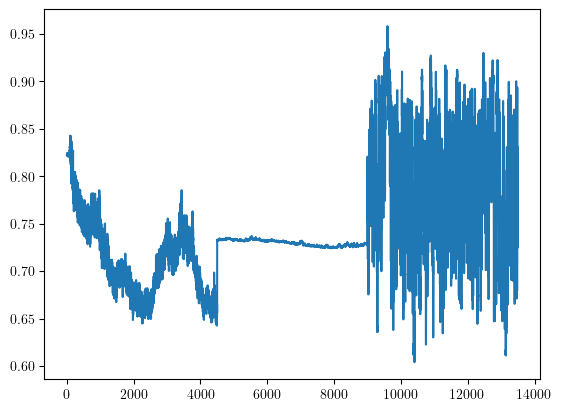

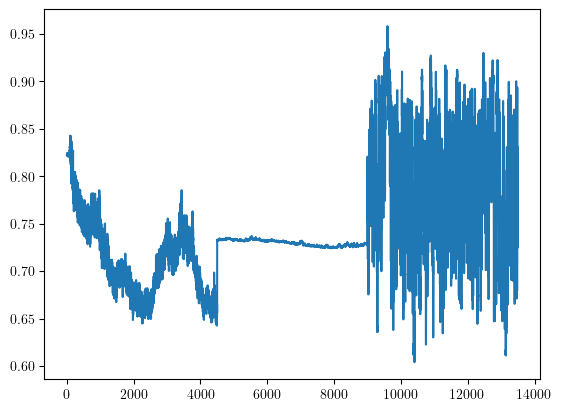

In [8]:
# samps.shape
pl.figure()
pl.plot(samps[:,ind_sigma8])



In [7]:
import matplotlib
%matplotlib inline
